**Book Recommendation Based on Client Data By RB**

In [79]:
#!pip install pandas
#!pip install seaborn
#!pip install matplotlib
#!pip install -U scikit-learn scipy matplotlib
#!pip install scipy

In [80]:
#Importing modules
import re
import pickle
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings("ignore")

**#User Data Preparation**

In [81]:
tags = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_tags.csv')
users_intrested_tag = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_user_interested_tag.csv')
users_media_records = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_user_media_record.csv')

In [82]:
users_media_records['Age'] = np.random.randint(10, 100, users_media_records.shape[0])
def flag_df(df):
    
    if (df['type'] ==0):
        return 'event'
    elif (df['type'] ==1):
        return 'bookbite'
    elif (df['type']==2):
        return 'conversation'
    elif (df['type']==3):
        return 'podcast'
    elif (df['type']==4):
        return 'ideaofday'
    elif (df['type']==5):
        return 'ecourse'
    elif (df['type'] ==6):
        return 'audiobookchapter'
    
users_media_records['type'] = users_media_records.apply(flag_df, axis = 1)
users_media_records.drop(['created_at', 'updated_at'], axis=1, inplace=True)
users_media_records

,id,user_id,media_id,leave_time,type,Age
0,2,14849,173,382,bookbite,62
1,4,11694,76,175,bookbite,19
2,6,11694,158,314,bookbite,91
3,7,11694,gid://art19-episode-locator/V0/WIhT5CD0BW2EVzF...,1323,podcast,57
4,8,11694,147,323,bookbite,89
...,...,...,...,...,...,...
28343,39039,42280,996,667,bookbite,71
28344,39040,36968,993,47,bookbite,26
28345,39041,57644,995,179,bookbite,18
28346,39042,57662,995,114,bookbite,52


In [83]:

## Checking null values
print(users_media_records.isna().sum())  

id            0
user_id       0
media_id      0
leave_time    0
type          0
Age           0
dtype: int64


In [84]:
## Drop duplicate rows
users_media_records.drop_duplicates(keep='last', inplace=True)
users_media_records.reset_index(drop=True, inplace=True)
     

In [85]:
# Users dataset information
users_media_records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28348 entries, 0 to 28347
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          28348 non-null  int64 
 1   user_id     28348 non-null  int64 
 2   media_id    28348 non-null  object
 3   leave_time  28348 non-null  int64 
 4   type        28348 non-null  object
 5   Age         28348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.3+ MB


In [86]:
# Checking for any duplicate values 
len(users_media_records[users_media_records.duplicated()])
# No duplicate

0

In [87]:
users_media_records.head()

,id,user_id,media_id,leave_time,type,Age
0,2,14849,173,382,bookbite,62
1,4,11694,76,175,bookbite,19
2,6,11694,158,314,bookbite,91
3,7,11694,gid://art19-episode-locator/V0/WIhT5CD0BW2EVzF...,1323,podcast,57
4,8,11694,147,323,bookbite,89


In [88]:
#users_media_records.drop(['leave_time', 'type','Age'], axis=1, inplace=True)
#users_media_records.head(3)

In [89]:
'''#printing the shape of all three data sets
print("tags Data:    ", tags.shape)
print("users_intrested_tag Data:    ", users_intrested_tag.shape)
print("users_media_records: ", users_media_records.shape)'''

'#printing the shape of all three data sets\nprint("tags Data:    ", tags.shape)\nprint("users_intrested_tag Data:    ", users_intrested_tag.shape)\nprint("users_media_records: ", users_media_records.shape)'

In [90]:
'''#Rename id to tag id in tag DB
tags.rename(columns={"id": "tag_id"}, inplace=True)
tags'''

'#Rename id to tag id in tag DB\ntags.rename(columns={"id": "tag_id"}, inplace=True)\ntags'

In [91]:
'''#merging both db so we can get tag names and delete irrelevant cols
users_intrested_tagnames = pd.merge(users_intrested_tag,tags[['tag_id','tagName']],on='tag_id', how='left')
users_intrested_tagnames.drop(['created_at', 'updated_at'], axis=1, inplace=True)
users_intrested_tagnames'''

"#merging both db so we can get tag names and delete irrelevant cols\nusers_intrested_tagnames = pd.merge(users_intrested_tag,tags[['tag_id','tagName']],on='tag_id', how='left')\nusers_intrested_tagnames.drop(['created_at', 'updated_at'], axis=1, inplace=True)\nusers_intrested_tagnames"

**Book Data prepartion : ITEAMS_SEARCH Table prepared as per recommendatio_data_preparation file**

In [92]:
BPC = pd.read_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/ITEMS_SEARCH_Table.csv')
BPC

,ITEM_ID,TITLE,AUTHOR_NAME,CATEGORY,CREATION_TIMESTAMP
0,gid://art19-episode-locator/V0/O9qUiVxFA9ic_f1...,Book Bite #4: Is Your Inner Child Your Truest ...,Stefanie Stahl,podcast,2022
1,gid://art19-episode-locator/V0/KKlzUp47OYeDibY...,Book Bite #5: Is It Time To Rethink Everything...,Adam Grant,podcast,2022
2,gid://art19-episode-locator/V0/gb8ERjyqL5AJ3cE...,Book Bite #6: Want to Know the Secret to Getti...,Annie Murphy Paul,podcast,2022
3,gid://art19-episode-locator/V0/77A3nksFpz8oysc...,Book Bite #7: Why Won’t the Voice in Your Head...,Ethan Kross,podcast,2022
4,gid://art19-episode-locator/V0/tEJB-uRC98ywB9N...,Book Bite #8: What if Being Delusional Is Good...,Shankar Vedantam,podcast,2022
...,...,...,...,...,...
1208,f0735625-ca0f-4d69-a1bd-1001a8792a08,Ethan Kross on Harnessing the Chatter in Our M...,NaN,ecourse,2021
1209,f37ad137-ac1e-4f45-a410-65e93fdf1588,Olga Khazan on The Power of Being an Outsider ...,NaN,ecourse,2021
1210,f40915eb-df24-455d-8605-c3082548d00f,Your Brain on Art: An Audio E-Course by Ivy Ro...,"Ivy Ross, Susan Magsamen",ecourse,2023
1211,f7170c76-708a-4e8b-bed2-99ea144d560d,Safi Bahcall on Nurturing the Ideas That Win W...,NaN,ecourse,2021


In [93]:
BPC.isnull().sum()

ITEM_ID                0
TITLE                  0
AUTHOR_NAME           51
CATEGORY               0
CREATION_TIMESTAMP     0
dtype: int64

In [94]:
BPC.loc[BPC['AUTHOR_NAME'].isnull(),:]

,ITEM_ID,TITLE,AUTHOR_NAME,CATEGORY,CREATION_TIMESTAMP
103,gid://art19-episode-locator/V0/ASrtVpX-SPOvI0L...,Introducing The Next Big Idea,NaN,podcast,2022
120,p123,CULTURE: How Successful Groups Work,NaN,podcast,2022
122,p125,How To Be a Grown-Up,NaN,podcast,2022
124,p127,"Susan Cain & Daniel Pink: Writing, Longing, an...",NaN,podcast,2022
125,p128,"BIG DATA: Cracking the Codes of Love, Happines...",NaN,podcast,2022
127,p130,THE ESSENTIALS: Our Favorite Moments From Seas...,NaN,podcast,2022
128,p131,Summer Getaway #1: The Beach (with Sarah Stodola),NaN,podcast,2022
129,p132,Summer Getaway #2: An American Odyssey (with B...,NaN,podcast,2022
131,p134,Summer Getaway #4: The Making of ‘Bull Durham’...,NaN,podcast,2022
132,p135,HAPPINESS: Arthur C. Brooks Shares His Roadmap...,NaN,podcast,2022


In [95]:
BPC.fillna('Other')

,ITEM_ID,TITLE,AUTHOR_NAME,CATEGORY,CREATION_TIMESTAMP
0,gid://art19-episode-locator/V0/O9qUiVxFA9ic_f1...,Book Bite #4: Is Your Inner Child Your Truest ...,Stefanie Stahl,podcast,2022
1,gid://art19-episode-locator/V0/KKlzUp47OYeDibY...,Book Bite #5: Is It Time To Rethink Everything...,Adam Grant,podcast,2022
2,gid://art19-episode-locator/V0/gb8ERjyqL5AJ3cE...,Book Bite #6: Want to Know the Secret to Getti...,Annie Murphy Paul,podcast,2022
3,gid://art19-episode-locator/V0/77A3nksFpz8oysc...,Book Bite #7: Why Won’t the Voice in Your Head...,Ethan Kross,podcast,2022
4,gid://art19-episode-locator/V0/tEJB-uRC98ywB9N...,Book Bite #8: What if Being Delusional Is Good...,Shankar Vedantam,podcast,2022
...,...,...,...,...,...
1208,f0735625-ca0f-4d69-a1bd-1001a8792a08,Ethan Kross on Harnessing the Chatter in Our M...,Other,ecourse,2021
1209,f37ad137-ac1e-4f45-a410-65e93fdf1588,Olga Khazan on The Power of Being an Outsider ...,Other,ecourse,2021
1210,f40915eb-df24-455d-8605-c3082548d00f,Your Brain on Art: An Audio E-Course by Ivy Ro...,"Ivy Ross, Susan Magsamen",ecourse,2023
1211,f7170c76-708a-4e8b-bed2-99ea144d560d,Safi Bahcall on Nurturing the Ideas That Win W...,Other,ecourse,2021


In [96]:
## Checking for column Year-of-publication
BPC['CREATION_TIMESTAMP'].unique()

array([2022, 2023, 2020, 2021])

In [97]:
## Uppercasing all alphabets in Id
BPC['ITEM_ID'] = BPC['ITEM_ID'].str.upper()

In [98]:
#checking info
BPC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ITEM_ID             1213 non-null   object
 1   TITLE               1213 non-null   object
 2   AUTHOR_NAME         1162 non-null   object
 3   CATEGORY            1213 non-null   object
 4   CREATION_TIMESTAMP  1213 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 47.5+ KB


In [99]:
## Drop duplicate rows
BPC.drop_duplicates(keep='last', inplace=True) 
BPC.reset_index(drop = True, inplace = True)

In [100]:
#checking info
BPC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ITEM_ID             1213 non-null   object
 1   TITLE               1213 non-null   object
 2   AUTHOR_NAME         1162 non-null   object
 3   CATEGORY            1213 non-null   object
 4   CREATION_TIMESTAMP  1213 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 47.5+ KB


In [101]:
BPC.rename(columns={'ITEM_ID': 'media_id', 'CATEGORY': 'type'}, inplace=True)


In [102]:

BPC["TITLE"]=BPC["TITLE"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
BPC.head()

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022


In [103]:
#printing top5 rows
BPC.head()
     

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022


In [104]:
BPC.to_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/BPC.csv', index=False)
BPC

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022
...,...,...,...,...,...
1208,F0735625-CA0F-4D69-A1BD-1001A8792A08,Ethan Kross on Harnessing the Chatter in Our M...,NaN,ecourse,2021
1209,F37AD137-AC1E-4F45-A410-65E93FDF1588,Olga Khazan on The Power of Being an Outsider ...,NaN,ecourse,2021
1210,F40915EB-DF24-455D-8605-C3082548D00F,Your Brain on Art An Audio E Course by Ivy Ros...,"Ivy Ross, Susan Magsamen",ecourse,2023
1211,F7170C76-708A-4E8B-BED2-99EA144D560D,Safi Bahcall on Nurturing the Ideas That Win W...,NaN,ecourse,2021


**Book Likes/Completed Data Preparation**

In [105]:
likes = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_like.csv')
likes.head()

,id,user_id,media_id,type,created_at,updated_at
0,14,26630,676,1,2023-03-21 10:47:28,2023-03-21 10:47:28
1,16,26630,734,1,2023-03-21 10:48:01,2023-03-21 10:48:01
2,19,43193,58,1,2023-03-21 10:55:25,2023-03-21 10:55:25
3,23,26630,382,1,2023-03-21 19:54:48,2023-03-21 19:54:48
4,27,26630,131,1,2023-03-21 19:55:04,2023-03-21 19:55:04


In [106]:
def flag_df(df):
    
    if (df['type'] ==0):
        return 'event'
    elif (df['type'] ==1):
        return 'bookbite'
    elif (df['type']==2):
        return 'conversation'
    elif (df['type']==3):
        return 'podcast'
    elif (df['type']==4):
        return 'ideaofday'
    elif (df['type']==5):
        return 'ecourse'
    elif (df['type'] ==6):
        return 'audiobookchapter'
    
likes['type'] = likes.apply(flag_df, axis = 1)
likes.drop(['created_at', 'updated_at'], axis=1, inplace=True)
likes['liked'] = 5
likes.head()

,id,user_id,media_id,type,liked
0,14,26630,676,bookbite,5
1,16,26630,734,bookbite,5
2,19,43193,58,bookbite,5
3,23,26630,382,bookbite,5
4,27,26630,131,bookbite,5


In [107]:
completed = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/vv_completed_media.csv')
completed.head()

,id,user_id,media_id,type,created_at,updated_at
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,3,2022-02-16 07:08:27,2022-02-16 07:08:27
1,2,14849,351,1,2022-02-16 07:32:42,2022-02-16 07:32:46
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,3,2022-02-16 07:34:12,2022-02-16 07:34:12
3,4,22862,340,1,2022-02-16 08:23:20,2022-02-16 08:23:20
4,5,1333,149,1,2022-02-16 10:33:25,2022-02-16 10:33:25


In [108]:
def flag_df(df):
    
    if (df['type'] ==0):
        return 'event'
    elif (df['type'] ==1):
        return 'bookbite'
    elif (df['type']==2):
        return 'conversation'
    elif (df['type']==3):
        return 'podcast'
    elif (df['type']==4):
        return 'ideaofday'
    elif (df['type']==5):
        return 'ecourse'
    elif (df['type'] ==6):
        return 'audiobookchapter'
    
completed['type'] = completed.apply(flag_df, axis = 1)
completed.drop(['created_at', 'updated_at'], axis=1, inplace=True)
completed['liked'] = 5
completed.head()

,id,user_id,media_id,type,liked
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5
1,2,14849,351,bookbite,5
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5
3,4,22862,340,bookbite,5
4,5,1333,149,bookbite,5


In [109]:
merged_df = pd.concat([completed, likes,users_media_records], ignore_index=True)
merged_df.fillna(0, inplace=True)
merged_df

,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0
...,...,...,...,...,...,...,...
119490,39039,42280,996,bookbite,0.0,667.0,71.0
119491,39040,36968,993,bookbite,0.0,47.0,26.0
119492,39041,57644,995,bookbite,0.0,179.0,18.0
119493,39042,57662,995,bookbite,0.0,114.0,52.0


In [110]:
## Checking for null values
merged_df.isnull().sum() 

id            0
user_id       0
media_id      0
type          0
liked         0
leave_time    0
Age           0
dtype: int64

In [111]:
## checking all ratings number or not
print(is_numeric_dtype(merged_df['liked']))

True


In [112]:
## Drop duplicate rows
merged_df.drop_duplicates(keep='last', inplace=True)
merged_df.reset_index(drop=True, inplace=True)
merged_df.head()

,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0


In [113]:
#Print a concise summary of a DataFrame
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119495 entries, 0 to 119494
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          119495 non-null  int64  
 1   user_id     119495 non-null  int64  
 2   media_id    119495 non-null  object 
 3   type        119495 non-null  object 
 4   liked       119495 non-null  float64
 5   leave_time  119495 non-null  float64
 6   Age         119495 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 6.4+ MB


In [114]:
merged_df.to_csv(r'//Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/merged.csv', index=False)
merged_df

,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0
...,...,...,...,...,...,...,...
119490,39039,42280,996,bookbite,0.0,667.0,71.0
119491,39040,36968,993,bookbite,0.0,47.0,26.0
119492,39041,57644,995,bookbite,0.0,179.0,18.0
119493,39042,57662,995,bookbite,0.0,114.0,52.0


In [115]:

merged_df.loc[(merged_df['user_id'] == 26448 )]

,id,user_id,media_id,type,liked,leave_time,Age
1060,1061,26448,110,podcast,5.0,0.0,0.0
1062,1063,26448,108,podcast,5.0,0.0,0.0
1796,1797,26448,107,podcast,5.0,0.0,0.0
1798,1799,26448,106,podcast,5.0,0.0,0.0
2731,2732,26448,70,bookbite,5.0,0.0,0.0
...,...,...,...,...,...,...,...
115163,32314,26448,721,bookbite,0.0,38.0,63.0
116312,34069,26448,1187,bookbite,0.0,40.0,51.0
116579,34482,26448,819,bookbite,0.0,221.0,73.0
118590,37634,26448,925,bookbite,0.0,231.0,40.0


In [116]:
rating = pd.read_csv(r'/Users/rachana/Rachana_Python_VS/Book Recommendation System/ml_recommendation_data/interactions_db.csv')
rating.head(10)

,USER_ID,ITEM_ID,TIMESTAMP,EVENT_TYPE,EVENT_VALUE
0,0,160,1649377965,NaN,5.000000
1,0,170,1625157204,NaN,0.172941
2,0,gid://art19-episode-locator/V0/EpdqSE9YxMHJX8T...,1624841818,NaN,0.917152
3,0,gid://art19-episode-locator/V0/kudndFcsEIzVTwH...,1624577883,NaN,0.982359
4,0,gid://art19-episode-locator/V0/s0rel2DVaE5WhO9...,1625077652,NaN,1.382107
5,0,gid://art19-episode-locator/V0/sYIF0eIsG9z64E2...,1624109358,NaN,0.839187
6,141,55,1690260755,NaN,5.000000
7,141,649,1690288226,NaN,5.000000
8,141,747,1692207009,NaN,5.000000
9,141,787,1694538333,NaN,5.000000


In [117]:
rating.rename(columns={'ITEM_ID': 'media_id', 'USER_ID': 'user_id', 'EVENT_VALUE': 'liked'}, inplace=True)
rating

,user_id,media_id,TIMESTAMP,EVENT_TYPE,liked
0,0,160,1649377965,NaN,5.000000
1,0,170,1625157204,NaN,0.172941
2,0,gid://art19-episode-locator/V0/EpdqSE9YxMHJX8T...,1624841818,NaN,0.917152
3,0,gid://art19-episode-locator/V0/kudndFcsEIzVTwH...,1624577883,NaN,0.982359
4,0,gid://art19-episode-locator/V0/s0rel2DVaE5WhO9...,1625077652,NaN,1.382107
...,...,...,...,...,...
119490,57735,986,1699047016,NaN,5.000000
119491,57754,1001,1699083832,NaN,5.000000
119492,57754,7,1699082949,NaN,5.000000
119493,57768,p208,1699122575,NaN,5.000000


**Data Visualization**

Text(0.5, 1.0, 'No of books by an author (Top 15)')

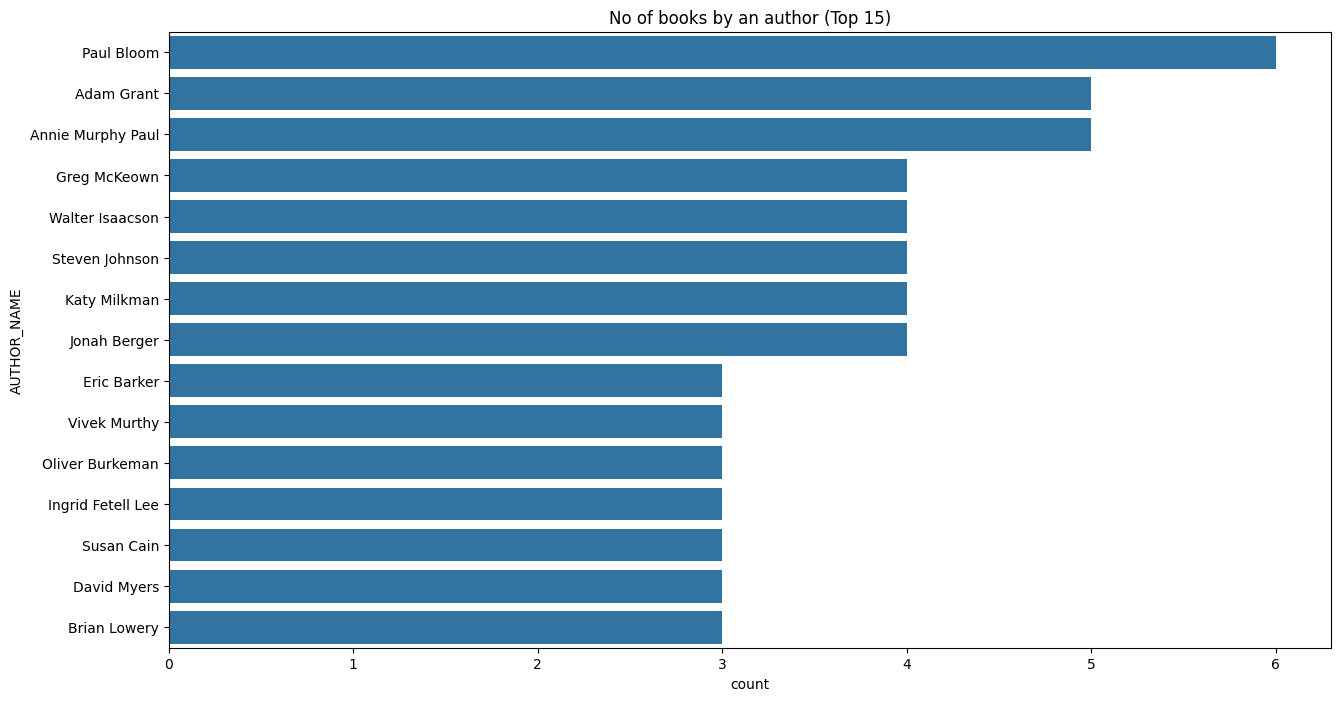

In [118]:
plt.figure(figsize=(15,8))
sns.countplot(y=BPC['AUTHOR_NAME'], data=BPC,order=BPC['AUTHOR_NAME'].value_counts().index[0:15])
plt.title("No of books by an author (Top 15)")

#Additionally there are many visuals we can implement such as top 15 books, type, year of book published,  author, users

Text(0.5, 1.0, 'Explicit Ratings/Liked')

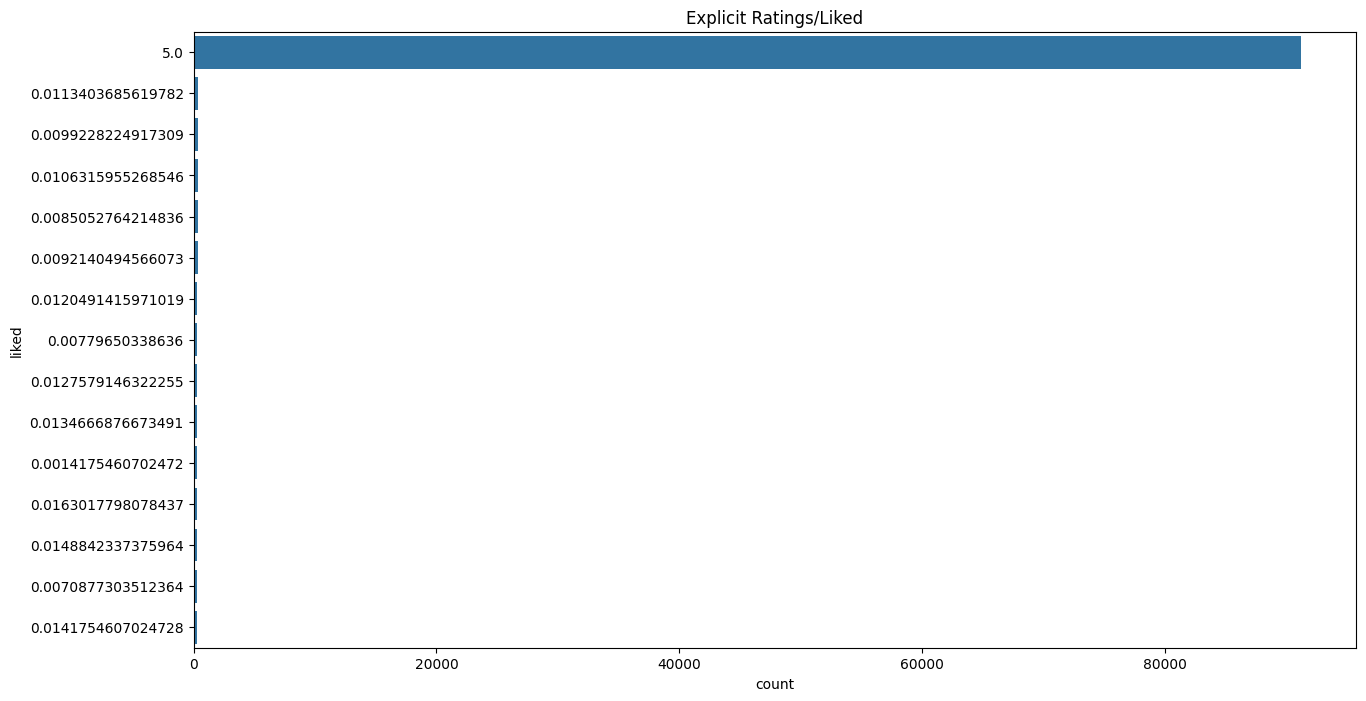

In [119]:
plt.figure(figsize=(15,8))
sns.countplot(y=rating['liked'], data=rating,order=rating['liked'].value_counts().index[0:15])
plt.title("Explicit Ratings/Liked")

#Additionally there are many visuals we can implement for liked dataset such as which year book published, who is the author and who like it

Text(0.5, 1.0, 'No of Books published every year')

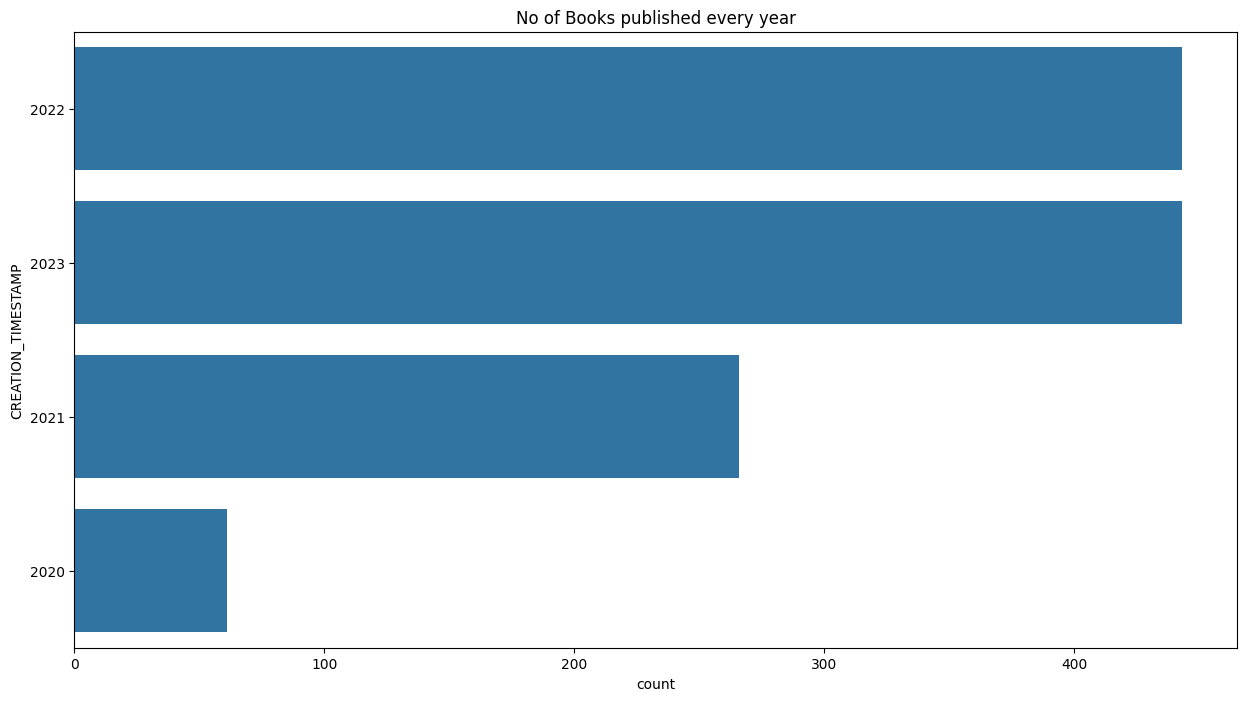

In [120]:
plt.figure(figsize=(15,8))
sns.countplot(y=BPC['CREATION_TIMESTAMP'], data=BPC,order=BPC['CREATION_TIMESTAMP'].value_counts().index[0:15])
plt.title("No of Books published every year")

#Additionally there are many visuals we can implement such as each year which type of book published, who is the author and who like it

In [121]:
#if we had user detail dataset then we can create visuals for user based on age, location, liked books, year wise activeness, type of book like etc although we dont have such information in current client data

**Combine Users, books, Liked merged df**

In [122]:
print("books Data:    ", BPC.shape)
BPC.head()

books Data:     (1213, 5)


,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,GID://ART19-EPISODE-LOCATOR/V0/O9QUIVXFA9IC_F1...,Book Bite 4 Is Your Inner Child Your Truest Self,Stefanie Stahl,podcast,2022
1,GID://ART19-EPISODE-LOCATOR/V0/KKLZUP47OYEDIBY...,Book Bite 5 Is It Time To Rethink Everything Y...,Adam Grant,podcast,2022
2,GID://ART19-EPISODE-LOCATOR/V0/GB8ERJYQL5AJ3CE...,Book Bite 6 Want to Know the Secret to Getting...,Annie Murphy Paul,podcast,2022
3,GID://ART19-EPISODE-LOCATOR/V0/77A3NKSFPZ8OYSC...,Book Bite 7 Why Won t the Voice in Your Head S...,Ethan Kross,podcast,2022
4,GID://ART19-EPISODE-LOCATOR/V0/TEJB-URC98YWB9N...,Book Bite 8 What if Being Delusional Is Good f...,Shankar Vedantam,podcast,2022


In [123]:
print("users_media_records: ", users_media_records.shape)
users_media_records.head()

users_media_records:  (28348, 6)


,id,user_id,media_id,leave_time,type,Age
0,2,14849,173,382,bookbite,62
1,4,11694,76,175,bookbite,19
2,6,11694,158,314,bookbite,91
3,7,11694,gid://art19-episode-locator/V0/WIhT5CD0BW2EVzF...,1323,podcast,57
4,8,11694,147,323,bookbite,89


In [124]:
print("rating Data:    ", rating.shape)
merged_df.head()

rating Data:     (119495, 5)


,id,user_id,media_id,type,liked,leave_time,Age
0,1,14849,gid://art19-episode-locator/V0/WFovDh9iW8WaRhZ...,podcast,5.0,0.0,0.0
1,2,14849,351,bookbite,5.0,0.0,0.0
2,3,14849,gid://art19-episode-locator/V0/4st0es1He1b1JuK...,podcast,5.0,0.0,0.0
3,4,22862,340,bookbite,5.0,0.0,0.0
4,5,1333,149,bookbite,5.0,0.0,0.0


In [125]:
dataset = pd.merge( BPC,rating, on=['media_id'], how='inner')
'''#merging users with above merged datset
dataset = pd.merge(dataset, users_media_records, on='media_id', how='inner')'''

## #Print a concise summary of a DataFrame
dataset.info()
dataset.drop(['TIMESTAMP', 'EVENT_TYPE'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98298 entries, 0 to 98297
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   media_id            98298 non-null  object 
 1   TITLE               98298 non-null  object 
 2   AUTHOR_NAME         98298 non-null  object 
 3   type                98298 non-null  object 
 4   CREATION_TIMESTAMP  98298 non-null  int64  
 5   user_id             98298 non-null  int64  
 6   TIMESTAMP           98298 non-null  int64  
 7   EVENT_TYPE          0 non-null      float64
 8   liked               98298 non-null  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 6.7+ MB


In [126]:
## Drop duplicate rows
dataset.drop_duplicates(keep='last', inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [127]:

dataset.loc[(dataset['media_id'] == "106" )]

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP,user_id,liked
0,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,587,5.00000
1,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,764,5.00000
2,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,872,0.01134
3,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,961,5.00000
4,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,1058,5.00000
...,...,...,...,...,...,...,...
459,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021,55281,5.00000
460,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021,56256,5.00000
461,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021,56773,5.00000
462,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021,56805,5.00000


In [128]:

dataset.loc[(dataset['media_id'] == "106" )& (dataset['user_id'] == 26444 )]

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP,user_id,liked
105,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,26444,5.0
337,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021,26444,5.0


In [129]:
dataset.head()

,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP,user_id,liked
0,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,587,5.00000
1,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,764,5.00000
2,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,872,0.01134
3,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,961,5.00000
4,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022,1058,5.00000


In [130]:
#merging users with above merged datset
dataset = pd.merge(dataset, users_media_records, on=['user_id','media_id'], how='outer')

## #Print a concise summary of a DataFrame

dataset.drop(['id', 'leave_time','Age','type_y'], axis=1, inplace=True)
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102166 entries, 0 to 102165
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   media_id            102166 non-null  object 
 1   TITLE               97657 non-null   object 
 2   AUTHOR_NAME         97657 non-null   object 
 3   type_x              97657 non-null   object 
 4   CREATION_TIMESTAMP  97657 non-null   float64
 5   user_id             102166 non-null  int64  
 6   liked               97657 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.5+ MB


In [131]:

dataset.loc[(dataset['media_id'] == "106" )& (dataset['user_id'] == 26444 )]

,media_id,TITLE,AUTHOR_NAME,type_x,CREATION_TIMESTAMP,user_id,liked
210,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,26444,5.0
211,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,26444,5.0


In [132]:

dataset.loc[(dataset['media_id'] == "106" )]

,media_id,TITLE,AUTHOR_NAME,type_x,CREATION_TIMESTAMP,user_id,liked
0,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,587,5.00000
1,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,587,5.00000
2,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,764,5.00000
3,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,764,5.00000
4,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,872,0.01134
...,...,...,...,...,...,...,...
459,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,56773,5.00000
460,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,56805,5.00000
461,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,56805,5.00000
462,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,57670,5.00000


In [133]:

dataset.loc[ (dataset['user_id'] == 26444 )]

,media_id,TITLE,AUTHOR_NAME,type_x,CREATION_TIMESTAMP,user_id,liked
210,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,26444,5.0
211,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,26444,5.0
596,107,Book Bite 2 Can You Get Ahead by Making Things...,Greg McKeown,podcast,2022.0,26444,5.0
597,107,BE 2 0 Beyond Entrepreneurship 2 0 Turning You...,Jim Collins,bookbite,2021.0,26444,5.0
9474,127,Think Again The Power of Knowing What You Don ...,Adam Grant,bookbite,2021.0,26444,5.0
17533,249,The Introvert s Edge to Networking Work the Ro...,Matthew Pollard,bookbite,2021.0,26444,5.0
18042,255,Sparked Discover Your Unique Imprint for Work ...,Jonathan Fields,bookbite,2021.0,26444,5.0
18278,258,The Long Game How to Be a Long Term Thinker in...,Dorie Clark,bookbite,2021.0,26444,5.0
24455,334,The End of Burnout Why Work Drains Us and How ...,Jonathan Malesic,bookbite,2022.0,26444,5.0
24761,336,I Didn t Do the Thing Today Letting Go of Prod...,Madeleine Dore,bookbite,2022.0,26444,5.0


In [134]:
## Drop duplicate rows
dataset.drop_duplicates(keep='last', inplace=True)
dataset.reset_index(drop=True, inplace=True)

In [135]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101889 entries, 0 to 101888
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   media_id            101889 non-null  object 
 1   TITLE               97385 non-null   object 
 2   AUTHOR_NAME         97385 non-null   object 
 3   type_x              97385 non-null   object 
 4   CREATION_TIMESTAMP  97385 non-null   float64
 5   user_id             101889 non-null  int64  
 6   liked               97385 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.4+ MB


**Recommendation**

In [136]:
#taking using input which book he/she choose
bookName = input("Enter a book name: ")
#no of recomendation they expected from our recomendation system
number = int(input("Enter number of books to recommend: "))
#user id for recommendation 
user = int(input("Enter number of books user to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

**1. Popularity Based (Top In whole collection)
Books in trend or are most popular among the users and directly recommend those.** **Popularity Based (Top In a type)** can be use difffernt popularity like age location type year etc

In [137]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('media_id')['liked'].count()).sort_values('liked', ascending=False).head(n)
        result = pd.merge(data, BPC, on='media_id', left_index = False)
        return result
    return "Invalid number of books entered!!"

In [138]:

print("Top", number, "Popular books are: ")
popularity_based(dataset, number)

Top 2 Popular books are: 


,media_id,liked,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,380,787,From Strength to Strength Finding Success Happ...,Arthur C. Brooks,bookbite,2022
1,339,640,Get It Done Surprising Lessons from the Scienc...,Ayelet Fishbach,bookbite,2022


**User based CF**

In [139]:
new_df=dataset[dataset['user_id'].map(dataset['user_id'].value_counts()) > 100] 
users_matrix=new_df.pivot_table(index=["user_id"],columns=["TITLE"],values="liked")
users_matrix.fillna(0, inplace=True)

In [140]:
def user_based_coll_rs(user_id):
    
    users_fav=new_df[new_df["user_id"]==user_id].sort_values(["liked"],ascending=False)[0:5]
    
    print("Ypur Top Favorite books: \n")

    for book in users_fav['TITLE']:
        
        print(book)
        print("Rating", end='->')
        print(round(dataset[dataset['TITLE'] == book]['liked'].mean(), 2))
        print("-"*50)
        
    print("\n\n")
    
    index=np.where(users_matrix.index==2033)[0][0]
    
    similarity=cosine_similarity(users_matrix)
    similar_users = list(enumerate(similarity[index]))
    similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[0:5]
    
    users_id=[]
    
    for i in similar_users:
        
            data=dataset[dataset["user_id"]==users_matrix.index[i[0]]]
            users_id.extend(list(data.drop_duplicates("user_id")["user_id"].values))


    x=new_df[new_df["user_id"]==user_id]
    recommend_books=[]
    user=list(users_id)
    
    for i in user:
        
        y=new_df[(new_df["user_id"]==i)]
        sim_books=y.loc[~y["TITLE"].isin(x["TITLE"]),:]
        sim_books=sim_books.sort_values(["liked"],ascending=False)[0:5]
        recommend_books.extend(sim_books["TITLE"].values)
    
    
    print("Recommended for you: \n")
        
    for book in recommend_books:
        print(book)
        print("Rating",end='->')
        print(round(dataset[dataset['TITLE'] == book]['liked'].mean(),2))
        print("-"*50)

In [141]:
user_based_coll_rs(user)

Ypur Top Favorite books: 

Do Hard Things Why We Get Resilience Wrong and the Surprising Science of Real Toughness
Rating->3.9
--------------------------------------------------
Ice From Mixed Drinks to Skating Rinks a Cool History of a Hot Commodity
Rating->4.23
--------------------------------------------------
Launchpad Republic America s Entrepreneurial Edge and Why It Matters
Rating->3.88
--------------------------------------------------
Inventor of the Future The Visionary Life of Buckminster Fuller
Rating->4.43
--------------------------------------------------
Last Rites The Evolution of the American Funeral
Rating->3.73
--------------------------------------------------





IndexError: index 0 is out of bounds for axis 0 with size 0

First we return the active users who have presented in the dataset more than 100 times

In [ ]:
new_df=dataset[dataset['user_id'].map(dataset['user_id'].value_counts()) > 100] 

In [ ]:
new_df.shape

(24699, 7)

Lets make our matrix, User as indcies, Books as columns and finally ratings as values

In [ ]:
users_matrix=new_df.pivot_table(index=["user_id"],columns=["TITLE"],values="liked")
users_matrix.head()

TITLE,1 Leadership Master the Small Daily Improvements that Set Great Leaders Apart,2030 How Today s Biggest Trends Will Collide and Reshape the Future of Everything,21 Lessons for the 21st Century,28 Days to Save the World Crafting Your Culture to Be Ready for Anything,8 Billion and Counting How Sex Death and Migration Shape Our World,8 Rules of Love How to Find It Keep It and Let It Go,A Brief History of Earth Four Billion Years in Eight Chapters,A Brief History of the Female Body An Evolutionary Look at How and Why the Female Form Came to Be,A Cure for Darkness The Story of Depression and How We Treat It,A Hacker s Mind How the Powerful Bend Society s Rules and How to Bend them Back,...,You Should Smile More How to Dismantle Gender Bias in the Workplace,You Will Own Nothing Your War with a New Financial World Order and How to Fight Back,You and Your Adult Child How to Grow Together in Challenging Times,You re About to Make a Terrible Mistake How Biases Distort Decision Making and What You Can Do to Fight Them,Young and Restless The Girls Who Sparked America s Revolutions,Your Brain on Art How the Arts Transform Us,Your Face Belongs to Us A Secretive Startup s Quest to End Privacy as We Know It,Your Future Self How to Make Tomorrow Better Today,Your Life Depends On It What You Can Do to Make Better Choices About Your Health,Your Turn How to Be an Adult
user_id,,,,,,,,,,,,,,,,,,,,,
485,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,...,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN
587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN
2077,NaN,5.0,5.0,0.57198,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN
4639,5.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN


return user favorite books

In [ ]:
user_id = 2077 # we assume we want to recommend for that user
users_fav=new_df[new_df["user_id"]==user_id].sort_values(["liked"],ascending=False)[0:5]
users_fav.head()

,media_id,TITLE,AUTHOR_NAME,type_x,CREATION_TIMESTAMP,user_id,liked
45988,463,Do Hard Things Why We Get Resilience Wrong and...,Steve Magness,bookbite,2022.0,2077,5.0
87100,876,Ice From Mixed Drinks to Skating Rinks a Cool ...,Amy Brady,bookbite,2023.0,2077,5.0
52127,512,Launchpad Republic America s Entrepreneurial E...,Howard Wolk & John Landry,bookbite,2022.0,2077,5.0
52057,511,Inventor of the Future The Visionary Life of B...,Alec Nevala-Lee,bookbite,2022.0,2077,5.0
50810,496,Last Rites The Evolution of the American Funeral,Todd Harra,bookbite,2022.0,2077,5.0


In [ ]:
index=np.where(users_matrix.index==2077)[0][0]
index

3

Calculate the similarity between the active user and other users

In [ ]:
users_matrix.fillna(0, inplace=True)

replace nan values with zero to calculate the similarity

In [ ]:
similarity=cosine_similarity(users_matrix)
similarity[0]


array([1.        , 0.31593825, 0.36825546, 0.17693507, 0.28295248,
       0.22518242, 0.26122006, 0.39406003, 0.22219425, 0.3127065 ,
       0.27737047, 0.12608559, 0.18325436, 0.2173344 , 0.28070421,
       0.40801061, 0.14225207, 0.31470758, 0.44458551, 0.36582518,
       0.28357442, 0.22134101, 0.47955364, 0.34317239, 0.38004524,
       0.31118563, 0.32345708, 0.28837594, 0.33181186, 0.34239309,
       0.5817062 , 0.19647028, 0.26308204, 0.18998285, 0.28232643,
       0.27705291, 0.26489205, 0.11327988, 0.26254761, 0.6336456 ,
       0.24939841, 0.39666985, 0.28534533, 0.38266762, 0.25631234,
       0.29140027, 0.26667407, 0.3021308 , 0.17474533, 0.29717827,
       0.36710716, 0.35308232, 0.44750554, 0.22179628, 0.5637266 ,
       0.21498218, 0.22645973, 0.34410968, 0.25085931, 0.3569106 ,
       0.24912222, 0.26835634, 0.29866811, 0.26110766, 0.34420141,
       0.41739186, 0.18897543, 0.32284248, 0.3762874 , 0.32099071,
       0.22306985, 0.262894  , 0.32972313, 0.26637296, 0.32354

getting users similar to the active user

In [ ]:
similar_users = list(enumerate(similarity[index]))
similar_users[:5]


[(0, 0.17693507326444946),
 (1, 0.08399896518192072),
 (2, 0.2038640420943074),
 (3, 1.0000000000000007),
 (4, 0.1952277131969492)]

sort them of course users with high similarity will come first so we can recommend their interest to the active user

In [ ]:
similar_users = sorted(similar_users,key = lambda x:x[1],reverse=True)[1:6]
similar_users

[(54, 0.286682530842301),
 (52, 0.2803181847913571),
 (30, 0.2714209386935355),
 (93, 0.2662276053844954),
 (87, 0.2607726480704551)]

return the user Id for the similair users



In [ ]:
user_rec=[]
    
for i in similar_users:
        data=dataset[dataset["user_id"]==users_matrix.index[i[0]]]
        user_rec.extend(list(data.drop_duplicates("user_id")["user_id"].values))

user_rec

[21388, 20968, 14464, 28993, 28136]

In [ ]:
x=new_df[new_df["user_id"]==user_id]
recommend_books=[]
user=list(user_rec)
for i in user:
    y=new_df[(new_df["user_id"]==i)]
    sim_books=y.loc[~y["TITLE"].isin(x["TITLE"]),:]
    sim_books=sim_books.sort_values(["TITLE"],ascending=False)[0:5]
    recommend_books.extend(sim_books["TITLE"].values)
    
recommend_books

['Your Turn How to Be an Adult',
 'Your Face Belongs to Us A Secretive Startup s Quest to End Privacy as We Know It',
 'Your Brain on Art How the Arts Transform Us',
 'You Will Own Nothing Your War with a New Financial World Order and How to Fight Back',
 'You Have to Be Prepared to Die Before You Can Begin to Live Ten Weeks in Birmingham That Changed America',
 'Your Turn How to Be an Adult',
 'Your Life Depends On It What You Can Do to Make Better Choices About Your Health',
 'Your Brain on Art How the Arts Transform Us',
 'You Will Own Nothing Your War with a New Financial World Order and How to Fight Back',
 'Worth the Risk How to Microdose Bravery to Grow Resilience Connect More and Offer Yourself to the World',
 'Your Turn How to Be an Adult',
 'Your Face Belongs to Us A Secretive Startup s Quest to End Privacy as We Know It',
 'Your Brain on Art How the Arts Transform Us',
 'You Will Own Nothing Your War with a New Financial World Order and How to Fight Back',
 'You Will Own Not

**2.Collaborative Filtering:User - Item Collaborative Filtering**

Collaborative Filtering Recommendation System works by considering user likes and finds cosine similarities in likes by several users to recommend books. To implement this, we took only those books' data that have at least 10 likes in all.

In [ ]:
dataset.head(3)

,media_id,TITLE,AUTHOR_NAME,type_x,CREATION_TIMESTAMP,user_id,liked
0,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,587,5.0
1,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,587,5.0
2,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,764,5.0


In [ ]:


dataset['Total-Ratings']=dataset.groupby('media_id')['liked'].transform('count')
#dataset['TITLE'] = dataset.index
#dataset.reset_index(level=0, inplace=True)
#dataset = dataset.drop('index',axis=1)
dataset
#df = dataset.merge(dataset, left_on = 'TITLE', right_on = 'TITLE', how = 'left')
#df = df.drop(['Year-Of-Publication','Publisher','Age','City','State','Country'], axis=1)

#df
     

,media_id,TITLE,AUTHOR_NAME,type_x,CREATION_TIMESTAMP,user_id,liked,Total-Ratings
0,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,587,5.00000,464
1,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,587,5.00000,464
2,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,764,5.00000,464
3,106,Leading from Anywhere The Essential Guide to M...,David Burkus,bookbite,2021.0,764,5.00000,464
4,106,Book Bite 3 How Do You Get Where You Want to Be,Katy Milkman,podcast,2022.0,872,0.01134,464
...,...,...,...,...,...,...,...,...
101884,1468,NaN,NaN,NaN,NaN,11237,NaN,0
101885,1468,NaN,NaN,NaN,NaN,57478,NaN,0
101886,1470,NaN,NaN,NaN,NaN,54049,NaN,0
101887,3d5c624b-b886-439f-bd29-bfbdf3b222df,NaN,NaN,NaN,NaN,3693,NaN,0


In [ ]:
popularity_threshold = 50
popular_book = dataset[dataset['Total-Ratings'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)

In [ ]:
testdf = pd.DataFrame()
testdf['media_id'] = popular_book['media_id']
testdf['liked'] = popular_book['liked']
testdf['user_id'] = popular_book['user_id']
testdf = testdf[['user_id','liked']].groupby(testdf['media_id'])
     

In [ ]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0

for groupKey in testdf.groups.keys():
    tempDict={}
    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]] = groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)
pairwiseSimilarity = cosine_similarity(vector)
     

In [ ]:
listOfDictonaries

[{1225: 5.0,
  3479: 5.0,
  3713: 5.0,
  4639: 5.0,
  5150: 5.0,
  5497: 5.0,
  5583: 5.0,
  10004: 5.0,
  10347: 5.0,
  11211: 5.0,
  11544: 5.0,
  12094: 5.0,
  12793: 5.0,
  13496: 5.0,
  13557: 5.0,
  14165: 5.0,
  14464: 5.0,
  15242: 5.0,
  15704: 5.0,
  17533: 5.0,
  19354: 0.0063789573161127,
  20156: 5.0,
  21174: 5.0,
  21388: 5.0,
  21534: 5.0,
  21569: 5.0,
  21724: 0.017719325878091,
  21862: 5.0,
  24249: 5.0,
  24455: 5.0,
  27016: 5.0,
  28866: 5.0,
  30101: 5.0,
  30735: 5.0,
  30743: 5.0,
  32375: 5.0,
  32492: 5.0,
  32608: 5.0,
  32616: 5.0,
  33765: 5.0,
  34766: 5.0,
  35026: 5.0,
  35115: 0.0396912899669239,
  37270: 5.0,
  37550: 5.0,
  37559: 5.0,
  38336: 5.0,
  38584: 5.0,
  38876: 5.0,
  39040: 5.0,
  39076: 5.0,
  39343: 5.0,
  39674: 5.0,
  42664: 5.0,
  43047: 5.0,
  43191: 5.0,
  45908: 5.0,
  49992: 5.0,
  51110: 5.0,
  51938: 5.0,
  52102: 5.0,
  52356: 5.0,
  54049: 5.0,
  55453: 5.0,
  55504: 5.0,
  56593: 5.0,
  57754: 5.0},
 {3479: 5.0,
  4639: 5.0

In [ ]:
def printBookDetails(bookID):
    print(dataset[dataset['media_id']==bookID]['TITLE'].values[0])
 

def getTopRecommandations(bookID):
    collaborative = []
    row = reverseIndexMap[bookID]
    print("Input Book:")
    printBookDetails(bookID)
    
    print("\nRECOMMENDATIONS:\n")
    
    mn = 0
    similar = []
    for i in np.argsort(pairwiseSimilarity[row])[:-2][::-1]:
          if dataset[dataset['media_id']==indexMap[i]]['TITLE'].values[0] not in similar:
                if mn>=number:
                      break
                mn+=1
                similar.append(dataset[dataset['media_id']==indexMap[i]]['TITLE'].values[0])
                printBookDetails(indexMap[i])
                collaborative.append(dataset[dataset['media_id']==indexMap[i]]['TITLE'].values[0])
    return collaborative

In [ ]:
k = list(dataset['TITLE'])
m = list(dataset['media_id'])

#Input was: Upstream: How to Solve Problems Before They Happen
collaborative = getTopRecommandations(m[k.index(bookName)])


Input Book:
Your Future Self How to Make Tomorrow Better Today

RECOMMENDATIONS:

The Datapreneurs The Promise of AI and the Creators Building Our Future
Ice From Mixed Drinks to Skating Rinks a Cool History of a Hot Commodity


***2.2Collaborative Filtering:Correlation Based***

For this model, we have created the correlation matrix considering only those books which have total ratings of more than 10. Then a user-book rating matrix is created. For the input book using the correlation matrix, top books are recommended.

In [ ]:
popularity_threshold = 10

user_count = dataset['user_id'].value_counts()
data = dataset[dataset['user_id'].isin(user_count[user_count >= popularity_threshold].index)]
rat_count = data['liked'].value_counts()
data = data[data['liked'].isin(rat_count[rat_count >= popularity_threshold].index)]

matrix = data.pivot_table(index='user_id', columns='media_id', values = 'liked').fillna(0)

In [ ]:

average_rating = pd.DataFrame(dataset.groupby('media_id')['liked'].mean())
average_rating['ratingCount'] = pd.DataFrame(likes.groupby('media_id')['liked'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,liked,ratingCount
media_id,,
723,4.402836,44.0
952,4.357073,37.0
380,3.843637,25.0
834,4.608251,21.0
372,3.727620,21.0


In [ ]:
isbn = BPC.loc[BPC['TITLE'] == bookName].reset_index(drop = True).iloc[0]['media_id']
row = matrix[isbn]
correlation = pd.DataFrame(matrix.corrwith(row), columns = ['Pearson Corr'])
corr = correlation.join(average_rating['ratingCount'])

res = corr.sort_values('Pearson Corr', ascending=False).head(number+1)[1:].index
corr_books = pd.merge(pd.DataFrame(res, columns = ['media_id']), BPC, on='media_id')
print("\n Recommended Books: \n")
corr_books


 Recommended Books: 



,media_id,TITLE,AUTHOR_NAME,type,CREATION_TIMESTAMP
0,878,The Right Call What Sports Teach Us About Work...,Sally Jenkins,bookbite,2023
1,877,The Datapreneurs The Promise of AI and the Cre...,"Bob Muglia, Steve Hamm",bookbite,2023


***2.3Collaborative Filtering: Nearest Neighbours Based***

kNN(k-Nearest Neighbors) as an algorithm seems to be inspired from real life. The full k-nearest neighbors algorithm works much in the way some of us ask for recommendations from our friends. First, we start with people whose taste we feel we share, and then we ask a bunch of them to recommend something to us. If many of them recommend the same thing, we deduce that we’ll like it as well. Our behaviour is guided by the friends we grew up with.kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors.

Here we assume that users who given ratings more than 200 are users who read atleast 20 books(suppose on user given rating 10/10 so minimum he read books(200 ratings/10 ratings per book=20).For statisfical significance we should consider only the data of user who given more than 200 ratings. To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [ ]:
data = (dataset.groupby(by = ['TITLE'])['liked'].count().reset_index().
        rename(columns = {'liked': 'Total-Rating'})[['TITLE', 'Total-Rating']])

result = pd.merge(data, dataset, on='TITLE', left_index = False)
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'TITLE', columns = 'user_id', values = 'liked').fillna(0)
up_matrix = csr_matrix(matrix)

In [ ]:

model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]])


Recommended books:

The Right Call What Sports Teach Us About Work and Life
The Datapreneurs The Promise of AI and the Creators Building Our Future


***2.4 Collaborative Filtering: SVD(Singular Value Decomposition) Based recommendation System***

SVD and NMF models comparison Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction. Surprise package provides implementation of those algorithms.

**Content Based**

This system recommends books by calculating similarities in Book Titles. For this, TF-IDF feature vectors were created for unigrams and bigrams of Book-Titles; only those books' data has been considered which are having at least 20 ratings.


In [ ]:

#seting thershold as 80
popularity_threshold = 80
# sort the result based on thershgold value
popular_book = result[result['Total-Rating'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
#print the shape of popular books
popular_book.shape
     


(75792, 9)

In [ ]:

#using TF vectorizer function
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
#fit the Tf vectoriser model
tfidf_matrix = tf.fit_transform(popular_book['TITLE'])
tfidf_matrix.shape
     

(75792, 4359)

In [ ]:
# normalising the df
normalized_df = tfidf_matrix.astype(np.float32)
#checking for cosine similarity
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
#checking the shape
cosine_similarities.shape

(75792, 75792)

In [ ]:
print("Recommended Books:\n")
isbn = BPC.loc[BPC['TITLE'] == bookName].reset_index(drop = True).iloc[0]['media_id']
content = []

idx = popular_book.index[popular_book['media_id'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['TITLE'][i] != bookName and popular_book['TITLE'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['TITLE'][i])
        content.append(popular_book['TITLE'][i])

for book in similar_items:
    print(book)

Recommended Books:

Thinking 101 How to Reason Better to Live Better
Imaginable How to See the Future Coming and Feel Ready for Anything Even Things That Seem Impossible Today


**Hybrid Approach (Content+Collaborative) Using percentile**

A hybrid recommendation system was built using the combination of both content-based filtering and collaborative filtering systems. A percentile score is given to the results obtained from both content and collaborative filtering models and is combined to recommend top n books.

In [ ]:
#creating a list
z = list()
k = float(1/number)
for x in range(number):
      z.append(1-k*x)

dictISBN = {}
#checking for recomendation using collebrative filtering
for x in collaborative:
      dictISBN[x] = z[collaborative.index(x)]

#using content based filtering to check the recomendations
for x in content:
    if x not in dictISBN:
        dictISBN[x] = z[content.index(x)]
    else:
        dictISBN[x] += z[content.index(x)]
# take common from both recomendation systems   
# store in a dict     
ISBN = dict(sorted(dictISBN.items(),key=operator.itemgetter(1),reverse=True))
w=0
#print("Input Book:\n")
#print the input book name
print(bookName)
#print the recomenmned books
print("\nRecommended Books:\n")
for x in ISBN.keys():
    if w>=number:
        break
    w+=1
    print(x)

Your Future Self How to Make Tomorrow Better Today

Recommended Books:

The Datapreneurs The Promise of AI and the Creators Building Our Future
Thinking 101 How to Reason Better to Live Better
